# Import modules

In [3]:
import os
import cv2
import imageio.v3 as imageio
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F

import os
import sys
# sys.path.append("FracTAL_ResUNet/)
sys.path.append("./GitHub/FracTAL_ResUNet/")
from tqdm.auto import tqdm
from scipy.ndimage import distance_transform_edt

# import visdom
# sys.path.append('resuneta/') # do we need this repo?
# sys.path.append('../../')

# from resuneta.bound_dist import get_distance, get_boundary

# from bound_dist import get_distance, get_boundary
# from loss import TanimotoDualLoss
# from resuneta.models.resunet_d6_causal_mtskcolor_ddist import *
from nn.loss.mtsk_loss import mtsk_loss

from models.semanticsegmentation.FracTAL_ResUNet import FracTAL_ResUNet_cmtsk

from sklearn.metrics import f1_score, matthews_corrcoef

import matplotlib.pyplot as plt
# %matplotlib inline

/home/kai_ma/miniconda3/envs/pytorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Class and Function Definitions

## Datasets

In [5]:
# Define your custom PyTorch dataset class
class CustomDataset(Dataset):
    def __init__(self, image_directory, label_directory, fold='train', image_names=None,
                 label_names=None, classes=[255], image_suffix='.jpeg', label_suffix='.png',
                 boundary_kernel_size=(3,3)):
        self.image_directory = image_directory
        self.label_directory = label_directory
        self.fold = fold
        self.image_suffix = image_suffix
        self.label_suffix = label_suffix
        self.classes = classes

        if image_names is None:
            image_names = os.listdir(image_directory)
            self.image_names = [x.split('.')[0] for x in image_names]
        else:
            self.image_names = image_names

        if label_names is None:
            self.label_names = image_names
        else:
            self.label_names = label_names

        self.boundary_kernel_size = boundary_kernel_size

    def __getitem__(self, item):
        image = np.zeros((256, 256, 3))
        image_path = os.path.join(self.image_directory,
                                  str(self.image_names[item]) + self.image_suffix)
        image_temp = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        nrow, ncol, nchannels = image_temp.shape
        image[:nrow, :ncol] = image_temp[:256, :256]

        extent_path = os.path.join(self.label_directory,
                                   str(self.label_names[item % len(self.label_names)]) + self.label_suffix)
        extent_mask = np.zeros((256, 256))
        extent_image = imageio.imread(extent_path)
        nrow, ncol = extent_image.shape
        extent_image = np.array(np.isin(extent_image, self.classes), dtype=np.uint8)
        extent_mask[:nrow, :ncol] = extent_image[:256, :256]

        if self.fold == 'train':
            # brightness augmentation
            image = np.minimum(np.random.uniform(low=0.8, high=1.25) * image, 255)

            # rotation augmentation
            k = np.random.randint(low=0, high=4)
            image = np.rot90(image, k, axes=(0, 1))
            extent_mask = np.rot90(extent_mask, k, axes=(0, 1))

            # flip augmentation
            if np.random.uniform() > 0.5:
                image = np.flip(image, axis=0)
                extent_mask = np.flip(extent_mask, axis=0)
            if np.random.uniform() > 0.5:
                image = np.flip(image, axis=1)
                extent_mask = np.flip(extent_mask, axis=1)

        image = image.astype(np.uint8)
        boundary_mask = get_boundary(extent_mask, kernel_size=self.boundary_kernel_size)
        distance_mask = get_distance(extent_mask)
        image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

        image = torch.from_numpy(np.moveaxis(image, -1, 0))
        image_hsv = torch.from_numpy(np.moveaxis(image_hsv, -1, 0)) / 255.
        extent_mask = torch.unsqueeze(torch.from_numpy(extent_mask), 0)
        boundary_mask = torch.unsqueeze(torch.from_numpy(boundary_mask), 0)
        distance_mask = torch.unsqueeze(torch.from_numpy(distance_mask), 0)

        return image, extent_mask, boundary_mask, distance_mask, image_hsv

    def __len__(self):
        return len(self.image_names)

# You can then create an instance of your CustomDataset and use it with a PyTorch DataLoader for training.

class PlanetDatasetWithClasses(Dataset):
    def __init__(self, image_directory, label_directory, fold='train', image_names=None,
                 label_names=None, classes=[255], image_suffix='.jpeg', label_suffix='.png',
                 boundary_kernel_size=(3, 3)):
        self.image_directory = image_directory
        self.label_directory = label_directory
        self.fold = fold
        self.image_suffix = image_suffix
        self.label_suffix = label_suffix
        self.classes = classes

        if image_names is None:
            image_names = os.listdir(image_directory)
            self.image_names = [x.split('.')[0] for x in image_names]
        else:
            self.image_names = image_names

        if label_names is None:
            self.label_names = image_names
        else:
            self.label_names = label_names

        self.boundary_kernel_size = boundary_kernel_size

    def __getitem__(self, item):
        image = np.zeros((256, 256, 3))
        image_path = os.path.join(self.image_directory,
                                  str(self.image_names[item]) + self.image_suffix)
        image_temp = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        nrow, ncol, nchannels = image_temp.shape
        image[:nrow, :ncol] = image_temp[:256, :256]

        extent_path = os.path.join(self.label_directory,
                                   str(self.label_names[item % len(self.label_names)]) + self.label_suffix)
        extent_mask = np.zeros((256, 256))
        extent_image = imageio.imread(extent_path)
        nrow, ncol = extent_image.shape
        extent_image = np.array(np.isin(extent_image, self.classes), dtype=np.uint8)
        extent_mask[:nrow, :ncol] = extent_image[:256, :256]

        if self.fold == 'train':
            # brightness augmentation
            image = np.minimum(np.random.uniform(low=0.8, high=1.25) * image, 255)

            # rotation augmentation
            k = np.random.randint(low=0, high=4)
            image = np.rot90(image, k, axes=(0, 1))
            extent_mask = np.rot90(extent_mask, k, axes=(0, 1))

            # flip augmentation
            if np.random.uniform() > 0.5:
                image = np.flip(image, axis=0)
                extent_mask = np.flip(extent_mask, axis=0)
            if np.random.uniform() > 0.5:
                image = np.flip(image, axis=1)
                extent_mask = np.flip(extent_mask, axis=1)

        image = image.astype(np.uint8)
        boundary_mask = get_boundary(extent_mask, kernel_size=self.boundary_kernel_size)
        distance_mask = get_distance(extent_mask)
        image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

        image = F.to_tensor(np.moveaxis(image, -1, 0))
        image_hsv = F.to_tensor(np.moveaxis(image_hsv, -1, 0)) / 255.
        extent_mask = torch.unsqueeze(torch.tensor(extent_mask), 0)
        boundary_mask = torch.unsqueeze(torch.tensor(boundary_mask), 0)
        distance_mask = torch.unsqueeze(torch.tensor(distance_mask), 0)

        return image, extent_mask, boundary_mask, distance_mask, image_hsv

    def __len__(self):
        return len(self.image_names)
    
class PlanetDatasetWithClassesFullPathsMasked(Dataset):

    def __init__(self, fold='train', image_names=None, label_names=None, classes=[1],
                 noncrop_classes=[2], boundary_kernel_size=(3, 3)):

        self.fold = fold
        self.classes = classes
        self.noncrop_classes = noncrop_classes
        self.image_names = image_names
        self.label_names = label_names
        self.boundary_kernel_size = boundary_kernel_size

    def __getitem__(self, item):
        image = np.zeros((256, 256, 3))
        image_path = self.image_names[item]
        image_temp = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        nrow, ncol, nchannels = image_temp.shape

        extent_path = self.label_names[item]
        extent_mask = np.zeros((256, 256))
        extent_original = imageio.imread(extent_path)
        nrow, ncol = extent_original.shape
        extent_image = np.array(np.isin(extent_original, self.classes), dtype=np.uint8)

        topleft_x, topleft_y = 0, 0
        if nrow > 256:
            topleft_x = np.random.choice(np.arange(0, nrow-256))
        if ncol > 256:
            topleft_y = np.random.choice(np.arange(0, ncol-256))

        image[:nrow, :ncol] = image_temp[topleft_x:topleft_x+256, topleft_y:topleft_y+256]
        extent_mask[:nrow, :ncol] = extent_image[topleft_x:topleft_x+256, topleft_y:topleft_y+256]

        noncrop_mask = np.zeros((256, 256))
        noncrop_image = np.array(np.isin(extent_original, self.noncrop_classes), dtype=np.uint8)
        noncrop_mask[:nrow, :ncol] = noncrop_image[topleft_x:topleft_x+256, topleft_y:topleft_y+256]

        if self.fold == 'train':
            # brightness augmentation
            image = np.minimum(np.random.uniform(low=0.8, high=1.25) * image, 255)

            # rotation augmentation
            k = np.random.randint(low=0, high=4)
            image = np.rot90(image, k, axes=(0,1))
            extent_mask = np.rot90(extent_mask, k, axes=(0,1))

            # flip augmentation
            if np.random.uniform() > 0.5:
                image = np.flip(image, axis=0)
                extent_mask = np.flip(extent_mask, axis=0)
            if np.random.uniform() > 0.5:
                image = np.flip(image, axis=1)
                extent_mask = np.flip(extent_mask, axis=1)

        image = image.astype(np.uint8)
        boundary_mask = get_boundary(extent_mask, kernel_size=self.boundary_kernel_size)
        distance_mask = get_distance(extent_mask)
        image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

        # Define label mask
        label_mask = np.array((extent_mask + boundary_mask + noncrop_mask) >= 1, dtype=np.float32)

        image = F.to_tensor(image)
        image_hsv = torch.tensor(image_hsv.transpose(2, 0, 1) / 255.0, dtype=torch.float32)
        
        # Create copies of the numpy arrays to ensure positive strides
        extent_mask_copy = extent_mask.copy()
        boundary_mask_copy = boundary_mask.copy()
        distance_mask_copy = distance_mask.copy()
        label_mask_copy = label_mask.copy()

        # Now convert the copied numpy arrays to tensors and unsqueeze
        extent_mask = torch.unsqueeze(torch.tensor(extent_mask_copy, dtype=torch.float32), 0)
        boundary_mask = torch.unsqueeze(torch.tensor(boundary_mask_copy, dtype=torch.float32), 0)
        distance_mask = torch.unsqueeze(torch.tensor(distance_mask_copy, dtype=torch.float32), 0)
        label_mask = torch.unsqueeze(torch.tensor(label_mask_copy, dtype=torch.float32), 0)
        
        return image, extent_mask, boundary_mask, distance_mask, image_hsv, label_mask

    def __len__(self):
        return len(self.image_names)

## Loss and metrics

In [6]:
# def dice_coef(x, y):
#     if isinstance(x, np.ndarray):
#         intersection = np.logical_and(x, y)
#         return 2. * np.sum(intersection) / (np.sum(x) + np.sum(y))
#     else:
#         intersection = torch.logical_and(x, y)
#         return 2. * torch.sum(intersection) / (torch.sum(x) + torch.sum(y))

# Commented out Visdom-related function
# def visdom_visualize_batch(vis, img, extent, boundary, distance,
#                            extent_pred, boundary_pred, distance_pred,
#                            hsv, hsv_pred, mask, title="Train images"):

#     img, extent, boundary, distance = img.cpu().numpy(), extent.cpu().numpy(), boundary.cpu().numpy(), distance.cpu().numpy()
#     extent_pred, boundary_pred = extent_pred.cpu().numpy(), boundary_pred.cpu().numpy()
#     distance_pred, hsv, hsv_pred = distance_pred.cpu().numpy(), hsv.cpu().numpy(), hsv_pred.cpu().numpy()
#     mask = mask.cpu().numpy()

#     # put everything in one window
#     batch_size, nchannels, nrows, ncols = img.shape
#     padding = 10
#     items = [img, hsv, hsv_pred, extent, extent_pred,
#              boundary, boundary_pred, distance, distance_pred,
#              mask]
#     result = np.zeros((3, len(items)*nrows + (len(items)-1)*padding, batch_size*ncols + (batch_size-1)*padding))

#     for j, item in enumerate(items):

#         if item.shape[1] == 1:
#             item = np.tile(item, (1,3,1,1)) * 255.

#         if j == 1 or j == 2: # convert HSV to RGB
#             item = np.moveaxis(item, 1, -1) * 255.
#             for i in range(batch_size):
#                 item[i] = cv2.cvtColor(item[i].astype(np.uint8), cv2.COLOR_HSV2RGB)
#             item = np.moveaxis(item, -1, 1)

#         for i in range(batch_size):
#             result[:, j*(nrows+padding):(j+1)*nrows+j*padding, i*(ncols+padding):(i+1)*ncols+i*padding] = item[i]
#     vis.images(result, nrow=1, win=title, opts={'title': title})

In [7]:
def get_boundary(mask, kernel_size=(3, 3)):
    kernel = np.ones(kernel_size, np.uint8)
    dilation = cv2.dilate(mask, kernel, iterations=1)
    return dilation - mask

def get_distance(mask):
    return distance_transform_edt(mask)

In [5]:
class Tanimoto(nn.Module):
    def __init__(self, smooth=1.0e-5, axis=(2, 3), weight=None, batch_axis=0):
        super(Tanimoto, self).__init__()
        self.axis = axis
        self.smooth = smooth

    def forward(self, preds, label):
        # Evaluate the mean volume of class per batch
        Vli = torch.mean(torch.sum(label, dim=self.axis), dim=0)
        wli = 1.0 / (Vli**2)  # weighting scheme

        # First turn inf elements to zero, then replace that with the maximum weight value
        wli = torch.where(torch.isinf(wli), torch.zeros_like(wli), wli)
        wli = torch.where(torch.isinf(wli), torch.max(wli) * torch.ones_like(wli), wli)

        rl_x_pl = torch.sum(label * preds, dim=self.axis)
        # This is sum of squares
        l = torch.sum(label * label, dim=self.axis)
        r = torch.sum(preds * preds, dim=self.axis)

        rl_p_pl = l + r - rl_x_pl

        tnmt = (torch.sum(wli * rl_x_pl, dim=1) + self.smooth) / (torch.sum(wli * rl_p_pl, dim=1) + self.smooth)

        return tnmt

class TanimotoWithDual(nn.Module):
    def __init__(self, smooth=1.0e-5, axis=(2, 3), weight=None, batch_axis=0):
        super(TanimotoWithDual, self).__init__()
        self.tanimoto = Tanimoto(smooth=smooth, axis=axis)

    def forward(self, preds, label):
        # Measure of overlap
        loss1 = self.tanimoto(preds, label)

        # Measure of non-overlap as inner product
        preds_dual = 1.0 - preds
        labels_dual = 1.0 - label
        loss2 = self.tanimoto(preds_dual, labels_dual)

        return 0.5 * (loss1 + loss2)


In [6]:
# class ftnmt_loss(nn.Module):
#     def __init__(self, depth=5, axis=[1,2,3], smooth=1.0e-5):
#         super(ftnmt_loss, self).__init__()

#         assert depth >= 0, ValueError("depth must be >= 0, aborting...")

#         self.smooth = smooth
#         self.axis = axis
#         self.depth = depth

#         if depth == 0:
#             self.depth = 1
#             self.scale = 1.
#         else:
#             self.depth = depth
#             self.scale = 1./depth

#     def inner_prod(self, prob, label):
#         prod = prob * label
#         prod = torch.sum(prod, dim=self.axis)
#         return prod

#     def tnmt_base(self, preds, labels):

#         tpl = self.inner_prod(preds, labels)
#         tpp = self.inner_prod(preds, preds)
#         tll = self.inner_prod(labels, labels)

#         num = tpl + self.smooth
#         scale = 1./self.depth
#         denum = 0.0

#         for d in range(self.depth):
#             a = 2.**d
#             b = -(2.*a-1.)

#             denum = denum + torch.reciprocal(a*(tpp+tll) + b * tpl + self.smooth)

#         result = num * denum * scale
#         return torch.mean(result)

#     def forward(self, preds, labels):

#         l1 = self.tnmt_base(preds, labels)
#         l2 = self.tnmt_base(1. - preds, 1. - labels)

#         result = 0.5 * (l1 + l2)

#         return 1. - result

class ftnmt_loss(torch.nn.Module):
    def __init__(self, depth=5, axis=[1, 2, 3], smooth=1.0e-5, **kwargs):
        super(ftnmt_loss, self).__init__(**kwargs)

        assert depth >= 0, ValueError("depth must be >= 0, aborting...")

        self.smooth = smooth
        self.axis = axis
        self.depth = depth

        if depth == 0:
            self.depth = 1
            self.scale = 1.
        else:
            self.depth = depth
            self.scale = 1. / depth

    def inner_prod(self, prob, label):
        prod = prob * label
        prod = torch.sum(prod, dim=self.axis)
        return prod

    def tnmt_base(self, preds, labels):

        tpl = self.inner_prod(preds, labels)
        tpp = self.inner_prod(preds, preds)
        tll = self.inner_prod(labels, labels)

        num = tpl + self.smooth
        scale = 1. / self.depth
        denum = 0.0
        for d in range(self.depth):
            a = 2. ** d
            b = -(2. * a - 1.)

            denum = denum + torch.reciprocal(a * (tpp + tll) + b * tpl + self.smooth)

        result = num * denum * scale
        return torch.mean(result, dim=0)

    def forward(self, preds, labels):

        l1 = self.tnmt_base(preds, labels)
        l2 = self.tnmt_base(1. - preds, 1. - labels)

        result = 0.5 * (l1 + l2)

        return 1. - result


class ftnmt_loss_masked(nn.Module):
    def __init__(self, depth=5, axis=[1,2,3], smooth=1.0e-5):
        super(ftnmt_loss_masked, self).__init__()

        assert depth >= 0, ValueError("depth must be >= 0, aborting...")

        self.smooth = smooth
        self.axis = axis
        self.depth = depth

        if depth == 0:
            self.depth = 1
            self.scale = 1.
        else:
            self.depth = depth
            self.scale = 1./depth

    def inner_prod(self, prob, label):
        prod = prob * label
        prod = torch.sum(prod, dim=self.axis)
        return prod

    def tnmt_base(self, preds, labels):

        tpl = self.inner_prod(preds, labels)
        tpp = self.inner_prod(preds, preds)
        tll = self.inner_prod(labels, labels)

        num = tpl + self.smooth
        scale = 1./self.depth
        denum = 0.0

        for d in range(self.depth):
            a = 2.**d
            b = -(2.*a-1.)

            denum = denum + torch.reciprocal(a*(tpp+tll) + b * tpl + self.smooth)

        result = num * denum * scale
        return torch.mean(result, dim=0)

    def forward(self, preds, labels, mask):

        preds = preds * mask

        preds_dual = 1. - preds
        labels_dual = 1. - labels
        preds_dual = preds_dual * mask
        labels_dual = labels_dual * mask

        l1 = self.tnmt_base(preds, labels)
        l2 = self.tnmt_base(preds_dual, labels_dual)

        result = 0.5 * (l1 + l2)

        return 1. - result

## Training functions

In [7]:
import torchmetrics
# Define the training function
def train_model(train_dataloader, model, tanimoto_dual, optimizer, epoch, args):
    model.train()
    device = args['device']

    # Initialize metrics
    # cumulative_loss = 0
    # accuracy = 0
    # f1 = 0
    # mcc = 0
    # dice = 0
    cumulative_loss = 0
    accuracy = torchmetrics.classification.BinaryAccuracy().to(args['device'])
    f1 = torchmetrics.classification.BinaryF1Score().to(args['device'])
    mcc = torchmetrics.classification.BinaryMatthewsCorrCoef().to(args['device'])
    dice = torchmetrics.Dice().to(args['device'])

    device = args['device']

    for batch_i, (img, extent, boundary, distance, hsv, mask) in enumerate(
        tqdm(train_dataloader, desc='Training epoch {}'.format(epoch))):
    # for batch_i, (img, extent, boundary, distance, hsv, mask) in enumerate(train_dataloader):
    # for batch_i, (img, extent, boundary, distance, hsv, mask) in enumerate(t):

        optimizer.zero_grad()
        # print(img.shape)
        img = img.to(device)
        extent = extent.to(device)
        boundary = boundary.to(device)
        distance = distance.to(device)
        hsv = hsv.to(device)
        mask = mask.to(device)
        nonmask = torch.ones(extent.shape).to(device)

        # logits, bound, dist, convc = model(img)
        logits, bound, dist = model(img)

        # Multi-task loss
        # TODO: wrap this in a custom loss function / class
        loss_extent = tanimoto_dual(logits, extent, mask)
        loss_boundary = tanimoto_dual(bound, boundary, mask)
        loss_distance = tanimoto_dual(dist, distance, mask)

        loss = 0.33 * (loss_extent + loss_boundary + loss_distance)  # + loss_hsv)
        loss.backward()
        optimizer.step()

        cumulative_loss += loss.item()

        # Update metrics based on every batch
        logits_reshaped = logits.view(logits.shape[0], -1)
        extent_reshaped = extent.view(extent.shape[0], -1)
        mask_reshaped = mask.view(mask.shape[0], -1)

        nonmask_idx = torch.nonzero(mask_reshaped, as_tuple=True)
        nonmask_idx = torch.stack(nonmask_idx).to(device)
        logits_masked = torch.gather(logits_reshaped, 1, nonmask_idx)
        extent_masked = torch.gather(extent_reshaped, 1, nonmask_idx)

        # Accuracy
        extent_predicted_classes = (logits_masked - 0.5).ceil()

        accuracy(extent_predicted_classes.int(), extent_masked.int())
        f1(extent_predicted_classes.int(), extent_masked.int())
        mcc(extent_predicted_classes.int(), extent_masked.int())
        dice(extent_predicted_classes.int(), extent_masked.int())
        # accuracy += (extent_predicted_classes == extent_masked).sum().item()

        # # F1 score
        # probabilities = torch.cat([(1 - logits_masked), logits_masked], dim=1)
        # f1 += f1_score(extent_masked.cpu().detach().numpy(), 
                       
        #                probabilities.cpu().numpy())

        # # MCC metric
        # # mcc += matthews_corrcoef(extent_masked.cpu().numpy(), probabilities.cpu().numpy())
        # mcc = 0
        # # Dice score
        # dice += dice_coef(extent_masked, extent_predicted_classes)

        # TEMPORARY to make visdom work
#         convc = hsv
#         if batch_i % args['visdom_every'] == 0:
#             # visdom_visualize_batch(args['visdom'], img, extent, boundary, distance,
#             #                        logits, bound, dist, hsv, convc, mask)
#             pass

    return cumulative_loss, accuracy.compute().item(), f1.compute().item(), mcc.compute().item(), dice.compute().item()

# Define the evaluation function
def evaluate_model(val_dataloader, model, tanimoto_dual, epoch, args):
    model.eval()

    # Initialize metrics
    # cumulative_loss = 0
    # accuracy = 0
    # f1 = 0
    # mcc = 0
    # dice = 0
    cumulative_loss = 0
    accuracy = torchmetrics.classification.BinaryAccuracy().to(args['device'])
    f1 = torchmetrics.classification.BinaryF1Score().to(args['device'])
    mcc = torchmetrics.classification.BinaryMatthewsCorrCoef().to(args['device'])
    dice = torchmetrics.Dice().to(args['device'])

    device = args['device']


    with torch.no_grad():
        for batch_i, (img, extent, boundary, distance, hsv, mask) in enumerate(
            tqdm(val_dataloader, desc='Validation epoch {}'.format(epoch))):

            img = img.to(device)
            extent = extent.to(device)
            boundary = boundary.to(device)
            distance = distance.to(device)
            hsv = hsv.to(device)
            mask = mask.to(device)
            nonmask = torch.ones(extent.shape).to(device)

            # logits, bound, dist, convc = model(img)
            logits, bound, dist = model(img)

            # Multi-task loss
            # TODO: wrap this in a custom loss function / class
            loss_extent = tanimoto_dual(logits, extent, mask)
            loss_boundary = tanimoto_dual(bound, boundary, mask)
            loss_distance = tanimoto_dual(dist, distance, mask)

            loss = 0.33 * (loss_extent + loss_boundary + loss_distance)  # + loss_hsv)

            cumulative_loss += loss.item()

            # Update metrics based on every batch
            logits_reshaped = logits.view(logits.shape[0], -1)
            extent_reshaped = extent.view(extent.shape[0], -1)
            mask_reshaped = mask.view(mask.shape[0], -1)

            nonmask_idx = torch.nonzero(mask_reshaped, as_tuple=True)
            nonmask_idx = torch.stack(nonmask_idx).to(device)
            logits_masked = torch.gather(logits_reshaped, 1, nonmask_idx)
            extent_masked = torch.gather(extent_reshaped, 1, nonmask_idx)

            # Accuracy
            extent_predicted_classes = (logits_masked - 0.5).ceil()
            # accuracy += (extent_predicted_classes == extent_masked).sum().item()

            accuracy(extent_predicted_classes.int(), extent_masked.int())
            f1(extent_predicted_classes.int(), extent_masked.int())
            mcc(extent_predicted_classes.int(), extent_masked.int())
            dice(extent_predicted_classes.int(), extent_masked.int())

            # # F1 score
            # probabilities = torch.cat([(1 - logits_masked), logits_masked], dim=1)
            # f1 += f1_score(extent_masked.cpu().numpy(), probabilities.cpu().numpy())

            # # MCC metric
            # # mcc += matthews_corrcoef(extent_masked.cpu().numpy(), probabilities.cpu().numpy())
            # mcc = 0
            # # Dice score
            # dice += dice_coef(extent_masked, extent_predicted_classes)

            # # TEMPORARY to make visdom work
            # convc = hsv
            # if batch_i % args['visdom_every'] == 0:
            #     # visdom_visualize_batch(args['visdom'], img, extent, boundary, distance,
            #     #                        logits, bound, dist, hsv, convc, mask, title="Val images")
            #     pass

    return cumulative_loss, accuracy.compute().item(), f1.compute().item(), mcc.compute().item(), dice.compute().item()

In [8]:
# from your_dataset_module import PlanetDatasetWithClassesFullPathsMasked
#from resuneta.models.resunet_d6_causal_mtskcolor_ddist import ResUNetD6 as ResUNet_d6
#from resuneta.models.resunet_d7_causal_mtskcolor_ddist import ResUNet_d7
from GitHub import FracTAL_ResUNet

# FracTAL_ResUNet_cmtsk, ftnmt_loss_masked
# from your_loss_module import tanimoto_dual


def run_africa(country, train_names, val_names, test_names,
               train_names_label, val_names_label, test_names_label,
               trained_model=None,
               epochs=100, lr=0.001, lr_decay=None,
               model_type='resunet-d6',
               n_filters=16, batch_size=8,
               depth=5, n_classes=1,
               month='janFebMar',
               codes_to_keep=[1, 2],
               folder_suffix='',
               boundary_kernel_size=3,
               ctx_name='cpu',
               gpu_id=0):

    # Set PyTorch device

    # device = torch.device("cuda:0" if ctx_name == 'gpu' else "cpu")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Set up names of directories and paths for saving
    if trained_model is None:
        folder_name = model_type + '_' + month + '_nfilter-' + str(n_filters) + \
                      '_depth-' + str(depth) + '_bs-' + str(batch_size) + '_lr-' + str(lr) + folder_suffix
        if lr_decay:
            folder_name = folder_name + '_lrdecay-' + str(lr_decay)

        # Define model
        # if model_type == 'resunet-d6':
        #     model = ResUNet_d6(n_filters_init=n_filters, n_classes=n_classes)
        # elif model_type == 'resunet-d7':
        #     model = ResUNet_d7(n_filters_init=n_filters, n_classes=n_classes)
        # elif model_type == 'fractal-resunet':
        #     model = FracTAL_ResUNet_cmtsk(nfilters_init=n_filters, norm_groups=1, depth=depth, NClasses=n_classes)
        model = FracTAL_ResUNet_cmtsk(nfilters_init=n_filters, norm_groups=1, depth=depth, NClasses=n_classes)
        dummy_input = torch.randn(8,3,256,256)
        model(dummy_input)
        model = nn.DataParallel(model)
        model.to(device)

    else:
        folder_name = model_type + '_' + month + '_nfilter-' + str(n_filters) + \
                      '_bs-' + str(batch_size) + '_lr-' + str(lr) + folder_suffix + '_finetuned'
        # if model_type == 'resunet-d6':
        #     model = ResUNet_d6(n_filters_init=n_filters, n_classes=n_classes)
        # elif model_type == 'resunet-d7':
        #     model = ResUNet_d7(n_filters_init=n_filters, n_classes=n_classes)
        model.load_state_dict(torch.load(trained_model))
        model.to(device)
    
    save_path = os.path.join('./experiments/', country, folder_name)
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    save_model_name = os.path.join(save_path, "model.pth")

    # Visdom
#     env_name = country + '_' + folder_name
#     vis = visdom.Visdom(env=env_name)

    # Arguments
    args = {
        'batch_size': batch_size,
        'ctx_name': ctx_name,
        'gpu': gpu_id,
#         'visdom': vis,
        'visdom_every': 20,
        'device': device
    }

    # Define train/val/test splits
    train_dataset = PlanetDatasetWithClassesFullPathsMasked(
        fold='train',
        image_names=train_names,
        label_names=train_names_label,
        classes=codes_to_keep,
        boundary_kernel_size=boundary_kernel_size)
    val_dataset = PlanetDatasetWithClassesFullPathsMasked(
        fold='val',
        image_names=val_names,
        label_names=val_names_label,
        classes=codes_to_keep,
        boundary_kernel_size=boundary_kernel_size)
    test_dataset = PlanetDatasetWithClassesFullPathsMasked(
        fold='test',
        image_names=test_names,
        label_names=test_names_label,
        classes=codes_to_keep,
        boundary_kernel_size=boundary_kernel_size)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    tanimoto_dual = ftnmt_loss_masked(depth=0) # Tanimoto_with_dual_masked()
    
    # Define loss function
    if lr_decay:
        schedule = optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay)

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Containers for metrics to log
    train_metrics = {'train_loss': [], 'train_acc': [], 'train_f1': [],
                     'train_mcc': [], 'train_dice': []}
    val_metrics = {'val_loss': [], 'val_acc': [], 'val_f1': [],
                   'val_mcc': [], 'val_dice': []}
    best_mcc = 0.0

    # Training loop
    for epoch in range(1, epochs + 1):
        # with tqdm(train_dataloader, desc='Training epoch {}'.format(epoch), position=0, leave=True) as t:
            # Training set
            train_loss, train_accuracy, train_f1, train_mcc, train_dice = train_model(
                train_dataloader, model, tanimoto_dual, optimizer, epoch, args)

            # Training set metrics
            train_loss_avg = train_loss / len(train_dataset)
            train_metrics['train_loss'].append(train_loss_avg)
            train_metrics['train_acc'].append(train_accuracy)
            train_metrics['train_f1'].append(train_f1)
            train_metrics['train_mcc'].append(train_mcc)
            train_metrics['train_dice'].append(train_dice)

            # Validation set
            val_loss, val_accuracy, val_f1, val_mcc, val_dice = evaluate_model(
                val_dataloader, model, tanimoto_dual, epoch, args)

            # Validation set metrics
            val_loss_avg = val_loss / len(val_dataset)
            val_metrics['val_loss'].append(val_loss_avg)
            val_metrics['val_acc'].append(val_accuracy)
            val_metrics['val_f1'].append(val_f1)
            val_metrics['val_mcc'].append(val_mcc)
            val_metrics['val_dice'].append(val_dice)

            print("Epoch {}:".format(epoch))
            print("    Train loss {:0.3f}, accuracy {:0.3f}, F1-score {:0.3f}, MCC: {:0.3f}, Dice: {:0.3f}".format(
                train_loss_avg, train_accuracy, train_f1, train_mcc, train_dice))
            print("    Val loss {:0.3f}, accuracy {:0.3f}, F1-score {:0.3f}, MCC: {:0.3f}, Dice: {:0.3f}".format(
                val_loss_avg, val_accuracy, val_f1, val_mcc, val_dice))

            # Save model based on best MCC metric
            if val_mcc > best_mcc:
                torch.save(model.state_dict(), save_model_name)
                best_mcc = val_mcc

            # Save metrics
            metrics = pd.concat([pd.DataFrame(train_metrics), pd.DataFrame(val_metrics)], axis=1)
            metrics.to_csv(os.path.join(save_path, 'metrics.csv'), index=False)

        # # Visdom
        # vis.line(Y=np.stack([train_metrics['train_loss'], val_metrics['val_loss']], axis=1),
        #          X=np.arange(1, epoch+1), win="Loss",
        #          opts=dict(legend=['train loss', 'val loss'], markers=False, title="Losses",
        #                    xlabel="Epoch", ylabel="Loss")
        #         )
        # vis.line(Y=np.stack([train_metrics['train_mcc'], val_metrics['val_mcc']], axis=1),
        #          X=np.arange(1, epoch+1), win="MCC",
        #          opts=dict(legend=['train MCC', 'val MCC'], markers=False, title="MCC",
        #                    xlabel="Epoch", ylabel="MCC")
        #         )

In [32]:
# Run the training and evaluation
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
# from sklearn.metrics import confusion_matrix

# ============================ #
# user-specified hyperparameters
# ============================ #
country = 'partial-france'
epochs = 100
lr = 0.001
lr_decay = None
n_filters = 32
depth = 6
n_classes = 1
batch_size = 8
model_type = 'fractal-resunet'  # 'resunet-d6'
month_name = '3month-separate'
codes_to_keep = list(range(1, 10)) + [11, 14, 15, 16, 17, 18, 19, 21, 24, 25, 26, 28]
ctx_name = 'gpu' #'gpu'
gpu_id = 0
boundary_kernel_size = (2, 2)



# trained_model = '../experiments/france/sherrie10k/' + \
#     'resunet-d6_2019_10_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001_1x-8x-downsampled/model.params'
trained_model = None
# splits_path = '../data/splits/sherrie10k_planetImagery_splits_20x20_4x-downsampled.csv'
splits_path = 'sherrie10k_planetImagery_splits_20x20_4x-downsampled.csv' # THIS NEEDS TO BE CREATED
splits_df = pd.read_csv(splits_path)
splits_df['image_id'] = splits_df['image_id'].astype(str).str.zfill(5)

# get all img and labels
all_img_names = []
all_label_names = []
img_dir = './data/image/3x_downsample/'
label_dir = './data/label/3x_downsample/'
# img_dir = './GitHub/FracTAL_ResUNet/data/france/images/'
# label_dir = './GitHub/FracTAL_ResUNet/data/france/labels/'
# subfolders = ['2x_downsample', '3x_downsample']

# for subfolder in subfolders:
#     label_folder_imgs = sorted(os.listdir(os.path.join(label_dir, subfolder)))
for label_name in sorted(os.listdir(label_dir)):
    for month in ["2019_04", "2019_07", "2019_10"]:
        img_name = label_name.split('.')[0] + '_' + month + '.tif'
        img_path = os.path.join(img_dir, img_name)
        all_img_names.append(img_path)
        label_path = os.path.join(label_dir, label_name)
        all_label_names.append(label_path)

# split imgs and labels into train/val/test
all_images = pd.DataFrame({'img_path': all_img_names})
all_images['image_id'] = all_images['img_path'].str.split('/').apply(
    lambda x: x[-1]).str.split('.').apply(
    lambda x: x[0]).str.split('_').apply(
    lambda x: x[0])
all_images = all_images.merge(splits_df[['image_id', 'fold']], on='image_id', how='left')
train_names = all_images[all_images['fold'] == 'train']['img_path'].values
val_names = all_images[all_images['fold'] == 'val']['img_path'].values
test_names = all_images[all_images['fold'] == 'test']['img_path'].values

all_labels = pd.DataFrame({'label_path': all_label_names})
all_labels['image_id'] = all_labels['label_path'].str.split('/').apply(
    lambda x: x[-1]).str.split('.').apply(
    lambda x: x[0])
all_labels = all_labels.merge(splits_df[['image_id', 'fold']], on='image_id', how='left')
train_names_label = all_labels[all_labels['fold'] == 'train']['label_path'].values
val_names_label = all_labels[all_labels['fold'] == 'val']['label_path'].values
test_names_label = all_labels[all_labels['fold'] == 'test']['label_path'].values
torch.backends.cudnn.enabled = False

run_africa(country, train_names, val_names, test_names,
           train_names_label, val_names_label, test_names_label,
           trained_model=trained_model,
           epochs=epochs, lr=lr, lr_decay=lr_decay,
           model_type=model_type, n_filters=n_filters, depth=depth, n_classes=n_classes,
           batch_size=batch_size, month=month_name,
           codes_to_keep=codes_to_keep,
           ctx_name=ctx_name,
           gpu_id=gpu_id,
           folder_suffix='_france_3x',
           boundary_kernel_size=boundary_kernel_size)

Hello
32
depth:= 0, nfilters: 32, nheads::8, widths::1
depth:= 1, nfilters: 64, nheads::16, widths::1
depth:= 2, nfilters: 128, nheads::32, widths::1
depth:= 3, nfilters: 256, nheads::64, widths::1
depth:= 4, nfilters: 512, nheads::128, widths::1
depth:= 5, nfilters: 1024, nheads::256, widths::1
depth:= 6, nfilters: 512, nheads::256, widths::1
depth:= 7, nfilters: 256, nheads::128, widths::1
depth:= 8, nfilters: 128, nheads::64, widths::1
depth:= 9, nfilters: 64, nheads::32, widths::1
depth:= 10, nfilters: 32, nheads::16, widths::1


/home/kai_ma/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Training epoch 1:   0%|          | 12/2534 [00:11<41:19,  1.02it/s]


KeyboardInterrupt: 

In [50]:
epochs = 100
lr = 0.001
lr_decay = None
n_filters = 32
depth = 6
n_classes = 1
batch_size = 8
model_type = 'fractal-resunet'  # 'resunet-d6'
month_name = '3month-separate'
codes_to_keep = list(range(1, 10)) + [11, 14, 15, 16, 17, 18, 19, 21, 24, 25, 26, 28]
ctx_name = 'gpu' #'gpu'
gpu_id = 0
boundary_kernel_size = (2, 2)
import torch
from torchsummary import summary
import hiddenlayer as hl
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

model = FracTAL_ResUNet_cmtsk(nfilters_init=n_filters, norm_groups=1, depth=depth, NClasses=n_classes)
model = model.to(device)
print(model)
# hl_graph = hl.build_graph(model, input_tensor)
# hl_graph.theme = hl.graph.THEMES["blue"].copy()
# hl_graph.save("model_visualization.png", format="png")






Hello
32
depth:= 0, nfilters: 32, nheads::8, widths::1
depth:= 1, nfilters: 64, nheads::16, widths::1
depth:= 2, nfilters: 128, nheads::32, widths::1
depth:= 3, nfilters: 256, nheads::64, widths::1
depth:= 4, nfilters: 512, nheads::128, widths::1
depth:= 5, nfilters: 1024, nheads::256, widths::1
depth:= 6, nfilters: 512, nheads::256, widths::1
depth:= 7, nfilters: 256, nheads::128, widths::1
depth:= 8, nfilters: 128, nheads::64, widths::1
depth:= 9, nfilters: 64, nheads::32, widths::1
depth:= 10, nfilters: 32, nheads::16, widths::1
FracTAL_ResUNet_cmtsk(
  (features): FracTAL_ResUNet_features(
    (conv_first): Conv2DNormed(
      (conv2d): LazyConv2d(0, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm_layer): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (convs_dn): ModuleList(
      (0): Sequential(
        (FracTALResNet_unit): FracTALResNet_unit(
          (block1): ResNet_v2_block(
            (BN1): BatchNorm2d(32, eps=1e-

In [36]:
import torch
from torch.utils.tensorboard import SummaryWriter

# Set the device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Initialize your model
model = FracTAL_ResUNet_cmtsk(nfilters_init=n_filters, norm_groups=1, depth=depth, NClasses=n_classes)
model = model.to(device)

# Create a dummy input tensor for the forward pass and move it to the correct device
dummy_input = torch.randn(8, 3, 256, 256).to(device)

# Perform a forward pass with the dummy input
model(dummy_input)

# Initialize the TensorBoard writer
writer = SummaryWriter()

# Create another dummy input tensor for TensorBoard and move it to the correct device
# Ensure this tensor has the same shape as the one used in the model's forward pass
tensorboard_input = torch.zeros(8, 3, 256, 256).to(device)

# Add the model graph to TensorBoard
writer.add_graph(model, tensorboard_input)

# Close the TensorBoard writer
writer.close()


Hello
32
depth:= 0, nfilters: 32, nheads::8, widths::1
depth:= 1, nfilters: 64, nheads::16, widths::1
depth:= 2, nfilters: 128, nheads::32, widths::1
depth:= 3, nfilters: 256, nheads::64, widths::1
depth:= 4, nfilters: 512, nheads::128, widths::1
depth:= 5, nfilters: 1024, nheads::256, widths::1
depth:= 6, nfilters: 512, nheads::256, widths::1
depth:= 7, nfilters: 256, nheads::128, widths::1
depth:= 8, nfilters: 128, nheads::64, widths::1
depth:= 9, nfilters: 64, nheads::32, widths::1
depth:= 10, nfilters: 32, nheads::16, widths::1


# Results

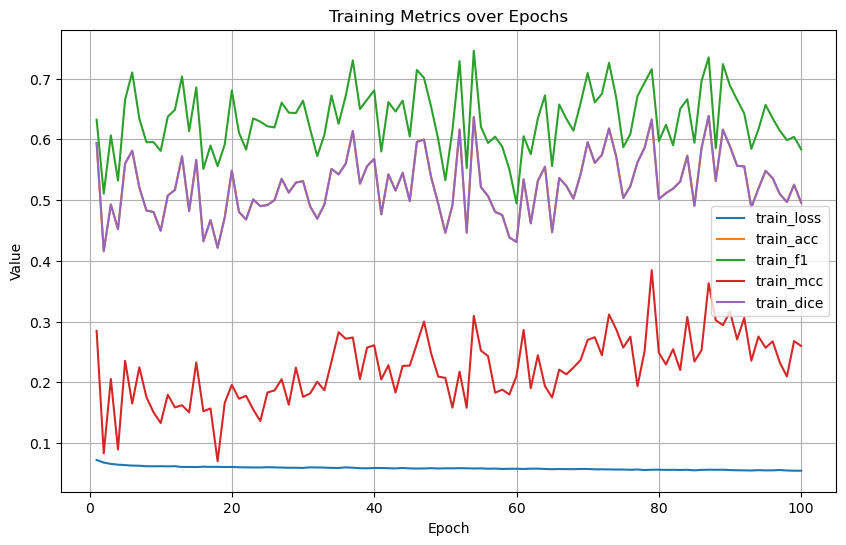

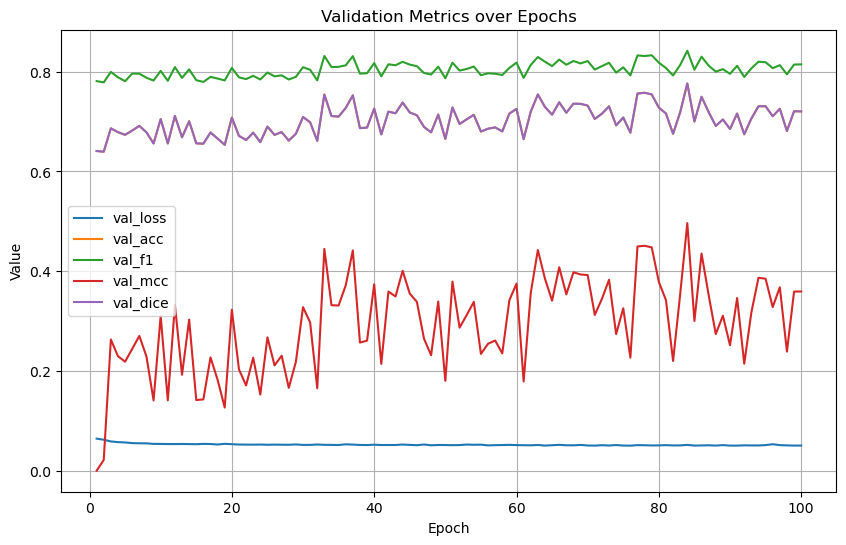

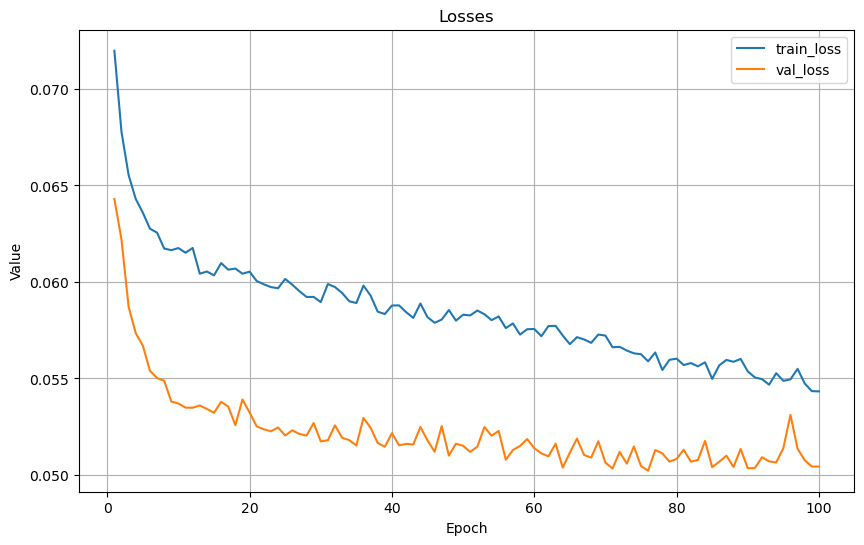

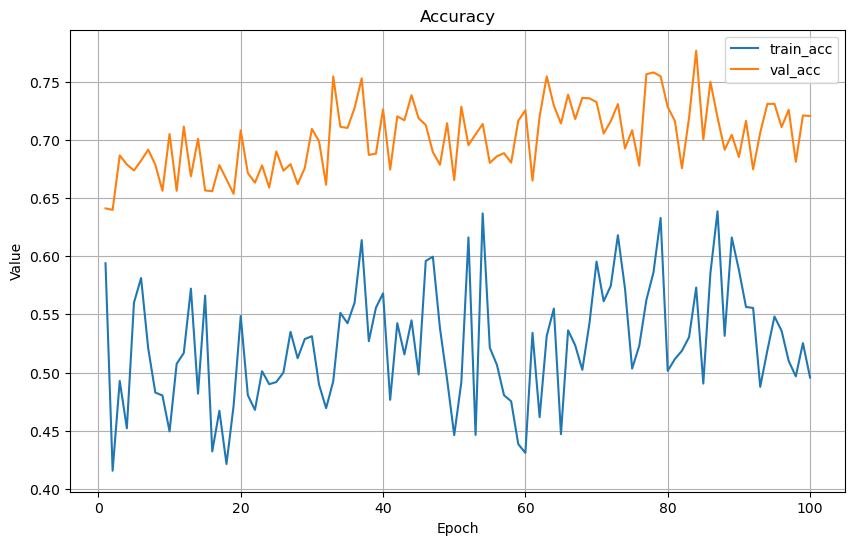

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
data = pd.read_csv("./experiments/partial-france/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_debugging_pytorch_code/metrics.csv")

# Extract metric columns
epochs = range(1, len(data) + 1)

# Function to plot metrics
def plot_metrics(metrics, title):
    plt.figure(figsize=(10, 6))
    for metric in metrics:
        plt.plot(epochs, data[metric], label=metric)
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot training metrics
train_metrics = ['train_loss', 'train_acc', 'train_f1', 'train_mcc', 'train_dice']
plot_metrics(train_metrics, 'Training Metrics over Epochs')

# Plot validation metrics
val_metrics = ['val_loss', 'val_acc', 'val_f1', 'val_mcc', 'val_dice']
plot_metrics(val_metrics, 'Validation Metrics over Epochs')

losses = ['train_loss', 'val_loss']
plot_metrics(losses, 'Losses')

losses = ['train_acc', 'val_acc']
plot_metrics(losses, 'Accuracy')

## Set model hyperparameters

# Old code dump

SHERRIE MXNET VERSION
